In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/momchil/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [6]:
# set source and solve for electromagnetic fields
simulation.src[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields()

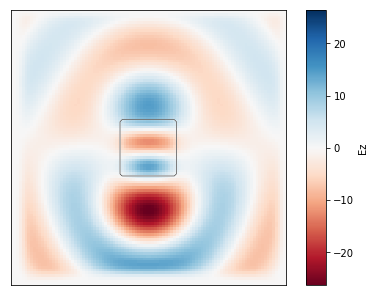

In [7]:
# plot linear field
simulation.plt_re(outline=True, cbar=True);

In [8]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

In [9]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region

In [20]:
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions,
                                      nonlin_fns={}, field_start='linear', solver='born', step_size=0.4)

100% (100 of 100) |######################| Elapsed Time: 0:00:11 ETA:  00:00:00

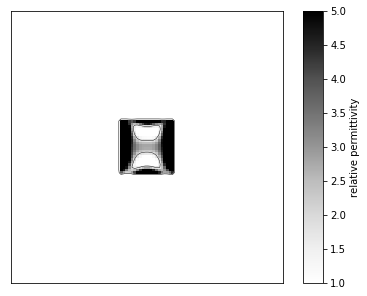

In [21]:
simulation.plt_eps()
plt.show()

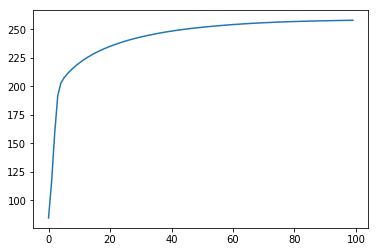

In [22]:
plt.plot(obj_fns)
plt.show()

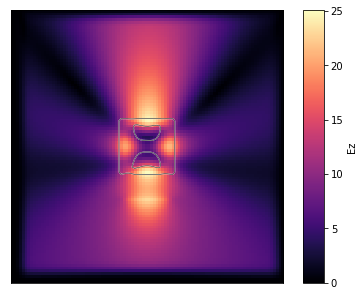

In [23]:
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
plt.show()

In [24]:
# Reset simulation
simulation.reset_eps(eps_r)

## Purely Nonlinear Optimization

In [25]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [27]:
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions, 
                           nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.4)

100% (100 of 100) |######################| Elapsed Time: 0:00:45 ETA:  00:00:00

In [58]:
# Note: takes a bit longer because the nonlinear solvers still need to solve twice to 
# know that the result is converged. Also the adjoint computation probably takes a bit longer
# Results look the same: 

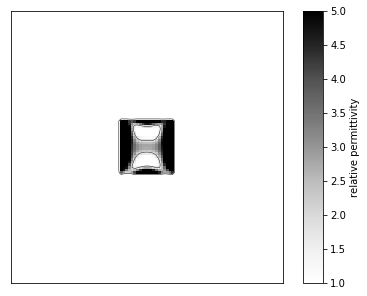

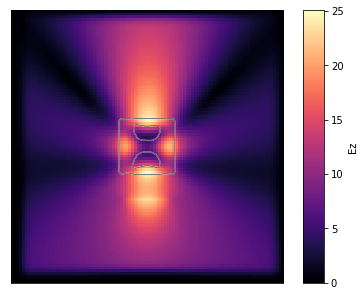

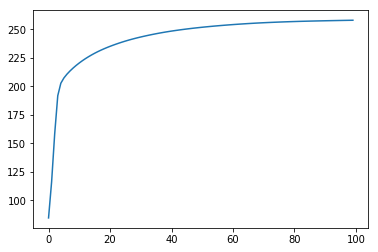

In [29]:
simulation.plt_eps()
plt.show()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()
plt.show()
plt.plot(obj_fns)
plt.show()

In [30]:
# Reset simulation
simulation.reset_eps(eps_r)

## Both Linear and Nonlinear

In [31]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['total']     = lambda J_lin, J_nonlin: J_lin - J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin - dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [33]:
Nsteps_both = 100
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps_both, eps_max, regions,
                                      nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.4)

100% (100 of 100) |######################| Elapsed Time: 0:01:24 ETA:  00:00:00

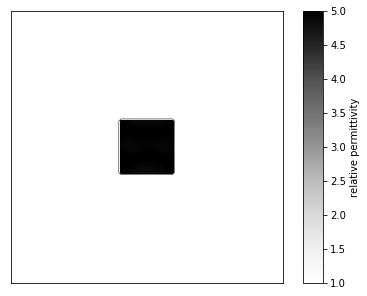

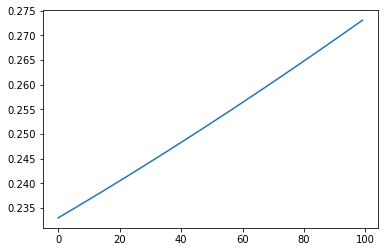

In [34]:
# note, it doesn't really change because the objective function is hard to satisfy 
# (respectively maximize and minimize linear and nonlinear intensity at point) 
# (the nonlinearity not high enough)
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

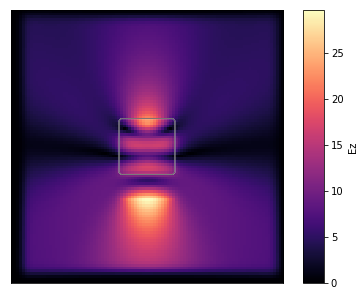

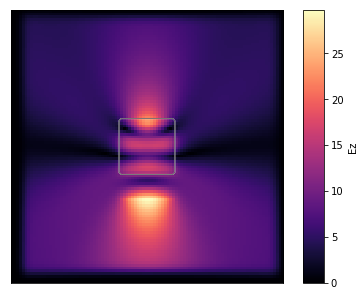

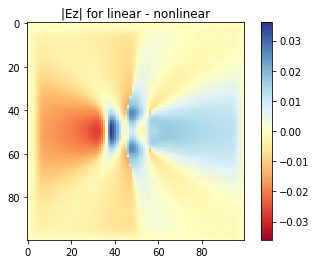

In [35]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez) - np.abs(Ez_nl)
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()


one can see from the last plot that the linear field is more intense at the measuring point, but only by a little bit.

## Nonlinear with larger input power

In [71]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [81]:
# Reset simulation and increase input power
simulation.src = 20*simulation.src
simulation.reset_eps(eps_r)

# Try first Born optimization 
# Note: step_size is much smaller because gradient is much larger (total amplitude of |Ez|^2 much larger than above)
# Some normalization would be nice
Nsteps = 20
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='linear', solver='born', step_size=0.001)

 45% (9 of 20) |###########              | Elapsed Time: 0:00:15 ETA:   0:00:29

the simulation did not converge, reached 2.493646546607959e-10


 50% (10 of 20) |############            | Elapsed Time: 0:00:18 ETA:   0:00:26

the simulation did not converge, reached 3.44058771762425e-09


 55% (11 of 20) |#############           | Elapsed Time: 0:00:20 ETA:   0:00:24

the simulation did not converge, reached 3.1860523306027e-08


 60% (12 of 20) |##############          | Elapsed Time: 0:00:23 ETA:   0:00:21

the simulation did not converge, reached 1.7929209429344928e-07


 65% (13 of 20) |###############         | Elapsed Time: 0:00:26 ETA:   0:00:21

the simulation did not converge, reached 2.0216323074293701e-07


 70% (14 of 20) |################        | Elapsed Time: 0:00:29 ETA:   0:00:17

the simulation did not converge, reached 1.5895366974707672e-06


 90% (18 of 20) |#####################   | Elapsed Time: 0:00:40 ETA:   0:00:06

the simulation did not converge, reached 1.2382055388183835e-10


100% (20 of 20) |########################| Elapsed Time: 0:00:47 ETA:  00:00:00

the simulation did not converge, reached 2.8485598028327e-10
the simulation did not converge, reached 2.1210187589955987e-10


In [27]:
# The simulation did not always reach the default convergence (1e-10). 
# It's a bit unstable, but still correct - see results below

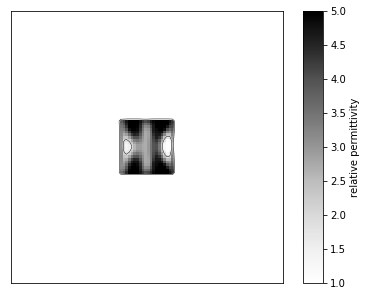

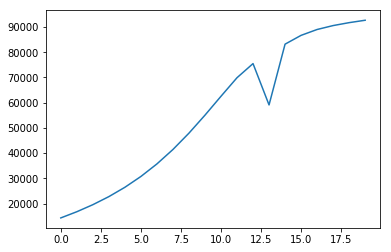

the simulation did not converge, reached 4.808485089785855e-10


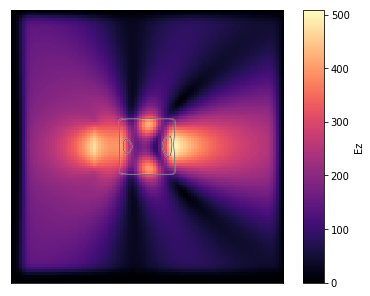

In [82]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')

simulation.plt_abs()

In [83]:
# Now let's try Newton
# Reset simulation
simulation.reset_eps(eps_r)
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='linear', solver='newton', step_size=0.001)

100% (20 of 20) |########################| Elapsed Time: 0:00:16 ETA:  00:00:00

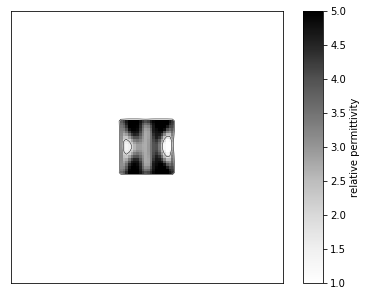

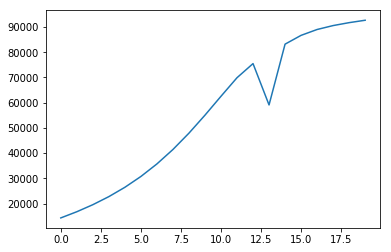

the simulation did not converge, reached 4.815383093063746e-10


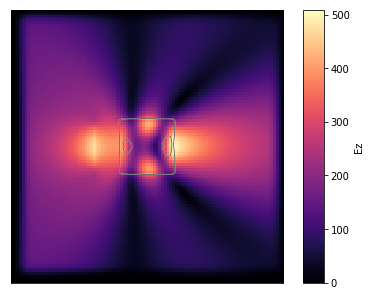

In [84]:
# It is both faster and more stable; still, the results are exactly the same because the Born computation was 
# essentially converged (maximum convergence was still ~2e-10)
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()

In [85]:
# Finally let's try using the "previous" fields instead of starting from the linear solution at every step

# Use Born
Nsteps = 20
simulation.reset_eps(eps_r)
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions, 
                           nonlin_fns=nonlin_fns, field_start='previous', solver='born', step_size=0.001)

 40% (8 of 20) |##########               | Elapsed Time: 0:00:14 ETA:   0:00:40

the simulation did not converge, reached 2.493648946103101e-10


 50% (10 of 20) |############            | Elapsed Time: 0:00:23 ETA:   0:00:35

the simulation did not converge, reached 3.440586007429941e-09


 55% (11 of 20) |#############           | Elapsed Time: 0:00:26 ETA:   0:00:29

the simulation did not converge, reached 3.186052386068861e-08


 60% (12 of 20) |##############          | Elapsed Time: 0:00:29 ETA:   0:00:26

the simulation did not converge, reached 1.7929209248948677e-07


 65% (13 of 20) |###############         | Elapsed Time: 0:00:32 ETA:   0:00:22

the simulation did not converge, reached 2.0216323147980647e-07


 70% (14 of 20) |################        | Elapsed Time: 0:00:36 ETA:   0:00:19

the simulation did not converge, reached 1.5895366964522016e-06


 90% (18 of 20) |#####################   | Elapsed Time: 0:00:48 ETA:   0:00:06

the simulation did not converge, reached 1.2381512140992862e-10


100% (20 of 20) |########################| Elapsed Time: 0:00:54 ETA:  00:00:00

the simulation did not converge, reached 2.8485091249144053e-10
the simulation did not converge, reached 2.121003646328291e-10


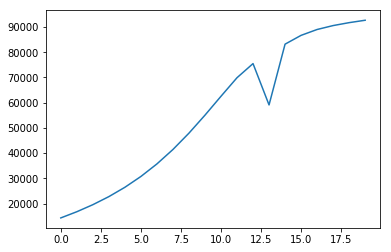

In [86]:
# Some poor stability
plt.plot(obj_fns)
plt.show()

In [1]:
# Reset simulation
simulation.reset_eps(eps_r)
# Use Newton
Nsteps = 20
(new_eps, obj_fns) = run_optimization(simulation, J, dJdE, Nsteps, eps_max, regions, nonlin_fns=nonlin_fns, field_start='previous', solver='newton', step_size=0.001)

NameError: name 'simulation' is not defined

ValueError: setting an array element with a sequence.

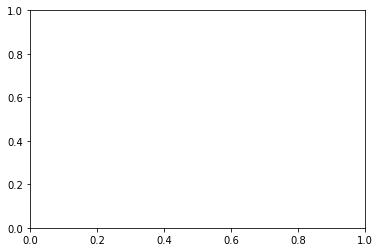

In [88]:
# Now this seems the same but more stable -T
plt.plot(obj_fns)
plt.show()